In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import torch
import torchvision
from petastorm import TransformSpec
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from functools import partial 
from torch import nn
from sklearn import preprocessing
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import FileLister
import torcharrow.dtypes as dt
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from torchvision import transforms
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data

/home/nuno/.local/lib/python3.10/site-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


In [2]:
spark = SparkSession \
    .builder \
    .appName("Data_Forecasting") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.driver.cores","4") \
    .config("spark.driver.maxResultSize","4g") \
    .config("spark.memory.offHeap.size","4g") \
    .config("spark.driver.memory", "4g")\
    .config("spark.executor.memory","4g")\
    .getOrCreate()

23/04/10 22:49:36 WARN Utils: Your hostname, nuno-g14 resolves to a loopback address: 127.0.1.1; using 192.168.1.7 instead (on interface wlp2s0)
23/04/10 22:49:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/10 22:49:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/10 22:49:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(dev)

cuda:0


## Auxiliary Functions

In [4]:
month_name = {
            'janeiro':'01',
            'fevereiro':'02',
            'março':'03',
            'abril':'04',
            'maio':'05',
            'junho':'06',
            'julho':'07',
            'agosto':'08',
            'setembro':'09',
            'outubro':'10',
            'novembro':'11',
            'dezembro':'12'}

In [5]:
def deal_with_null_date(dataframe):
    new_date_list = []

    for row in dataframe.rdd.collect():
        new_date_list.append(row.Date) 

    for index, elem in enumerate(new_date_list):
        if elem == None:
            new_date_list[index] = new_date_list[index-1]
    
    pandas_df = dataframe.toPandas()
    pandas_df = pandas_df.assign(Date=new_date_list)
    new_dataframe = spark.createDataFrame(pandas_df) 
    return new_dataframe

In [6]:
def deal_with_extense_date(dataframe):
    new_date_list = []

    for row in dataframe.rdd.collect():
        new_date = row.Date.split(' ')
        new_month = month_name[new_date[0].lower()]
        new_year = new_date[2]
        new_date_list.append(new_year + '/' + new_month) 

    
    pandas_df = dataframe.toPandas()
    pandas_df = pandas_df.assign(Date=new_date_list)
    new_dataframe = spark.createDataFrame(pandas_df) 
    return new_dataframe

In [7]:
def deal_with_bad_values(dataframe):
    for col in dataframe.columns:
        if col != 'Date':
            dataframe = dataframe.withColumn(col, dataframe[col].cast(DoubleType()))
    return dataframe

## Data Reading

In [8]:
li = []

files = os.path.join("/home/nuno/Desktop/MSc_Model_Datasets/Data_INE", "*.csv")
files = glob.glob(files)

for filename in files:
    sparkDF = spark.read.csv(filename, header='true', sep = ';')
    # df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
    li.append(sparkDF)

In [9]:
total_list = []

In [10]:
total_earnings = li[0].select("Date", "TE_Total_Portugal")
total_list.append(total_earnings)
# total_earnings.show(1)

In [11]:
total_landed = li[1].select("Date", "Landed_Portugal")
total_list.append(total_landed)
# total_landed.show(1)

In [12]:
total_overnight_stays = li[3].select("Date", "OS_Total_Portugal")
total_list.append(total_overnight_stays)
# total_overnight_stays.show(1)

In [13]:
total_avg_stay = li[5].select("Date", "Avg_Stay_Total")
total_list.append(total_avg_stay)

# total_avg_stay.show(1)

In [14]:
total_bed_net_rate = li[7].select("Date", "BNR_Total")
total_list.append(total_bed_net_rate)

# total_bed_net_rate.show(1)

In [15]:
total_guests = li[8].select("Date", "Guests_Total_Portugal")
total_list.append(total_guests)

# total_guests.show(1)

In [16]:
df0 = total_list[0]
for df in total_list:
    if df0 != df:
        df0 = df0.join(df,["Date"], "outer")

frame = df0

In [17]:
frame.show()

+-------------+-----------------+---------------+-----------------+--------------+---------+---------------------+
|         Date|TE_Total_Portugal|Landed_Portugal|OS_Total_Portugal|Avg_Stay_Total|BNR_Total|Guests_Total_Portugal|
+-------------+-----------------+---------------+-----------------+--------------+---------+---------------------+
|Abril de 1963|             null|          26880|             null|          null|     null|                 null|
|Abril de 1964|             null|          34430|             null|          null|     null|                 null|
|Abril de 1965|             null|          45337|             null|          null|     null|                 null|
|Abril de 1966|             null|          58515|             null|          null|     null|                 null|
|Abril de 1967|             null|          63931|             null|          null|     null|                 null|
|Abril de 1968|             null|          77815|             null|          nul

In [18]:
frame.describe().show()

+-------+----------------+------------------+-----------------+------------------+-------------------+-----------------+---------------------+
|summary|            Date| TE_Total_Portugal|  Landed_Portugal| OS_Total_Portugal|     Avg_Stay_Total|        BNR_Total|Guests_Total_Portugal|
+-------+----------------+------------------+-----------------+------------------+-------------------+-----------------+---------------------+
|  count|             671|                71|              671|                35|                 48|              108|                   35|
|   mean|            null|288603.23943661974|698727.5441860465|3684890.2285714285| 2.5083333333333324| 41.0861111111111|   1422789.5142857144|
| stddev|            null| 182768.8306137772|707814.7860388606| 2633739.147116801|0.24739780467672953|14.09401979851728|    928624.8212788303|
|    min|   Abril de 1963|            106775|                 |           1031062|                2.1|             20.3|              1025974|

In [19]:
frame.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in frame.columns]
   ).show()

+----+-----------------+---------------+-----------------+--------------+---------+---------------------+
|Date|TE_Total_Portugal|Landed_Portugal|OS_Total_Portugal|Avg_Stay_Total|BNR_Total|Guests_Total_Portugal|
+----+-----------------+---------------+-----------------+--------------+---------+---------------------+
|   0|              600|              0|              636|           623|      563|                  636|
+----+-----------------+---------------+-----------------+--------------+---------+---------------------+



In [20]:
frame.count()

671

In [21]:
frame = deal_with_extense_date(frame)
frame = deal_with_bad_values(frame)

/home/nuno/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/nuno/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [22]:
frame = frame.withColumn('Date', \
         to_timestamp('Date', 'yyyy/MM'))

In [23]:
frame.show()

+-------------------+-----------------+---------------+-----------------+--------------+---------+---------------------+
|               Date|TE_Total_Portugal|Landed_Portugal|OS_Total_Portugal|Avg_Stay_Total|BNR_Total|Guests_Total_Portugal|
+-------------------+-----------------+---------------+-----------------+--------------+---------+---------------------+
|1963-04-01 00:00:00|             null|        26880.0|             null|          null|     null|                 null|
|1964-04-01 00:00:00|             null|        34430.0|             null|          null|     null|                 null|
|1965-04-01 00:00:00|             null|        45337.0|             null|          null|     null|                 null|
|1966-04-01 00:00:00|             null|        58515.0|             null|          null|     null|                 null|
|1967-04-01 00:00:00|             null|        63931.0|             null|          null|     null|                 null|
|1968-04-01 00:00:00|           

In [24]:
frame = frame.sort(col("Date").asc())

In [25]:
frame = frame.withColumn('Date', \
         unix_timestamp('Date', 'yyyy/MM'))

In [26]:
frame = frame.select("Date", "Landed_Portugal", "BNR_Total")

In [27]:
frame = frame.na.drop()

In [28]:
frame.count()

108

In [29]:
data_INE = frame.toPandas()

In [30]:
display(data_INE)

,Date,Landed_Portugal,BNR_Total
0,1230768000,752961.0,21.7
1,1233446400,746104.0,27.4
2,1235865600,903641.0,30.2
3,1238540400,1211426.0,39.0
4,1241132400,1220875.0,39.6
...,...,...,...
103,1501542000,2809914.0,71.2
104,1504220400,2638478.0,60.4
105,1506812400,2388673.0,50.9
106,1509494400,1652930.0,34.8


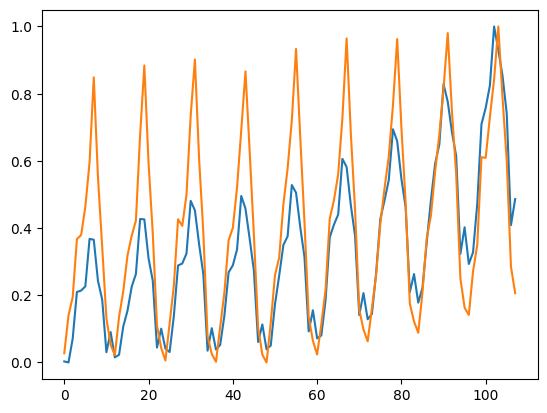

In [32]:
timeseries_landed = data_INE[["Landed_Portugal"]].values.astype('float32')

timeseries_bnr = data_INE[["BNR_Total"]].values.astype('float32')

min_max_scaler = preprocessing.MinMaxScaler()
timeseries_landed = min_max_scaler.fit_transform(timeseries_landed)
timeseries_bnr = min_max_scaler.fit_transform(timeseries_bnr)

plt.plot(timeseries_landed) # blue line
plt.plot(timeseries_bnr) # orange line
plt.show()

In [34]:
train_size = int(len(timeseries_landed) * 0.7)
test_size = len(timeseries_landed) - train_size
train_feature, test_feature = timeseries_landed[:train_size], timeseries_landed[train_size:]
train_target, test_target = timeseries_bnr[:train_size], timeseries_bnr[train_size:]

In [40]:
def create_dataset(feature_dataset, target_dataset, lookback):
    X, y = [], []
    for i in range(len(feature_dataset)-lookback):
        feature = feature_dataset[i:i+lookback]
        target = target_dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [77]:
lookback = 12
X_train, y_train = create_dataset(train_feature,train_target,lookback=lookback)
X_test, y_test = create_dataset(test_feature,test_target,lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([63, 12, 1]) torch.Size([63, 12, 1])
torch.Size([21, 12, 1]) torch.Size([21, 12, 1])


In [78]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [79]:
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_train.cpu()))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_test.cpu()))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.3174, test RMSE 0.3909
Epoch 10: train RMSE 0.2521, test RMSE 0.2609
Epoch 20: train RMSE 0.1594, test RMSE 0.2706
Epoch 30: train RMSE 0.1359, test RMSE 0.1864
Epoch 40: train RMSE 0.1243, test RMSE 0.1733
Epoch 50: train RMSE 0.1165, test RMSE 0.1712
Epoch 60: train RMSE 0.1106, test RMSE 0.1695
Epoch 70: train RMSE 0.1062, test RMSE 0.1668
Epoch 80: train RMSE 0.1025, test RMSE 0.1725
Epoch 90: train RMSE 0.0978, test RMSE 0.1617
Epoch 100: train RMSE 0.0922, test RMSE 0.1619
Epoch 110: train RMSE 0.0873, test RMSE 0.1627
Epoch 120: train RMSE 0.0846, test RMSE 0.1702
Epoch 130: train RMSE 0.0822, test RMSE 0.1670
Epoch 140: train RMSE 0.0811, test RMSE 0.1681
Epoch 150: train RMSE 0.0799, test RMSE 0.1669
Epoch 160: train RMSE 0.0790, test RMSE 0.1685
Epoch 170: train RMSE 0.0787, test RMSE 0.1677
Epoch 180: train RMSE 0.0792, test RMSE 0.1655
Epoch 190: train RMSE 0.0780, test RMSE 0.1696


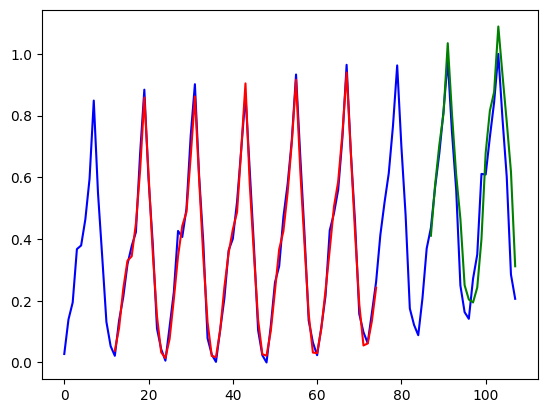

In [80]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries_bnr) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries_bnr) * np.nan
    test_plot[train_size+lookback:len(timeseries_bnr)] = model(X_test).cpu()[:, -1, :]
# plot
plt.plot(timeseries_bnr, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()